In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import hadamard, subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import os
import sys
parent_dir = os.path.dirname(os.getcwd())  # Get the parent directory
sys.path.append(parent_dir)
from kernel_sca_inducing_points import *
from utils import *
from kernels import *
import jPCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

import wandb

In [6]:
X = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy").swapaxes(1,2) 
X, _ = pre_processing(X, soft_normalize='max', center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                
A = A.reshape(N,-1)    

c = 30
d = 3

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 4.421685695648193, S_ratio: 0.07845126837491989
Iteration 10, S: 13.521013259887695, S_ratio: 0.20944096148014069
Iteration 20, S: 22.30731201171875, S_ratio: 0.2583797872066498
Iteration 30, S: 70.14253234863281, S_ratio: 0.32348912954330444
Iteration 40, S: 83.79808807373047, S_ratio: 0.3335394263267517
Iteration 50, S: 103.43062591552734, S_ratio: 0.36458441615104675
Iteration 60, S: 113.81902313232422, S_ratio: 0.3844524025917053
Iteration 70, S: 127.26348114013672, S_ratio: 0.3764724135398865
Iteration 80, S: 171.8563995361328, S_ratio: 0.39803633093833923
Iteration 90, S: 174.3577880859375, S_ratio: 0.3985934853553772
Iteration 100, S: 140.837890625, S_ratio: 0.432319700717926
Iteration 110, S: 237.26119995117188, S_ratio: 0.429621160030365
Iteration 120, S: 245.09844970703125, S_ratio: 0.4057985544204712
Iteration 130, S: 266.9781494140625, S_ratio: 0.41417238116264343
Iteration 140, S: 302.8177795410156, S_ratio: 0.41560661792755127
Iteration 150, S: 330.0074157

Text(0.5, 0.92, 's = 0.35576677322387695')

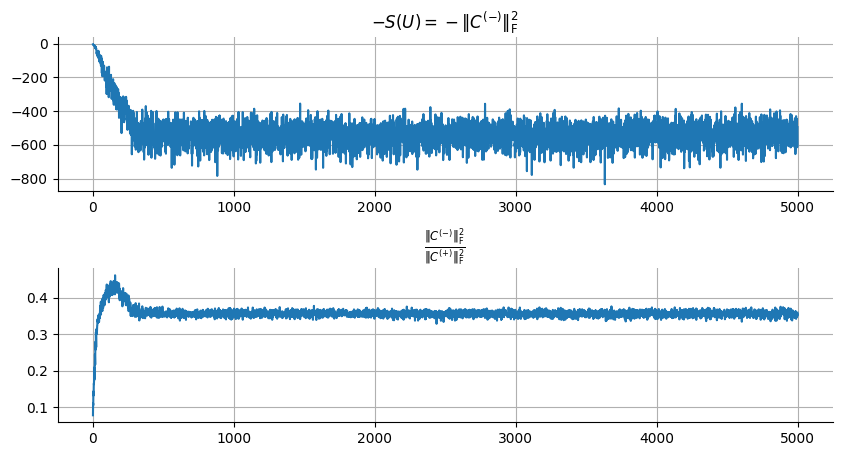

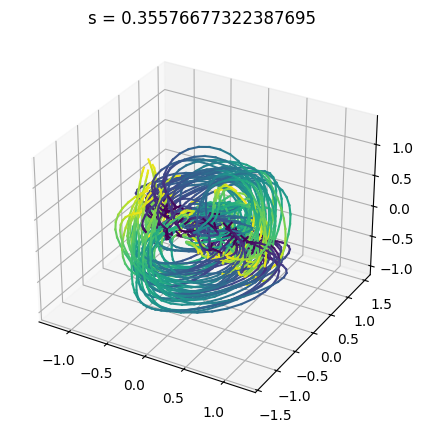

In [4]:
kernel_function = K_X_Y_squared_exponential

wandb.init(project="SCA-project-MC_Maze", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=5000, learning_rate=1e-3, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio)

_, u, l2 = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = K_X_Y_squared_exponential(u, X_reshaped, l2=l2).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_3D(Y[:,:,:])
plt.title(f's = {compute_S_all_pairs(Y)}')

In [ ]:
test = np.load('/Users/ariellerosinski/My Drive/params_4d_gaussian.npy', allow_pickle=True).tolist()

0.069217555


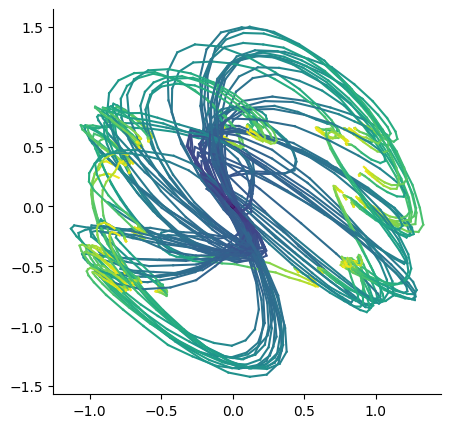

In [25]:
test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_2d_behaviour.npy')
plot_2D(test)
print(compute_S_all_pairs(jnp.array(test)))

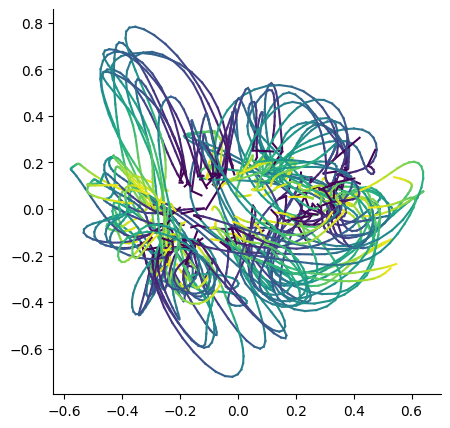

In [3]:
plot_2D( np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_2d.npy") )

In [5]:
pca_variance_captured

array([0.1537977 , 0.11750001, 0.07709902, 0.07201292, 0.06436612,
       0.04355825, 0.04204386, 0.03679934, 0.03264692, 0.0308856 ],
      dtype=float32)

In [7]:
np.cumsum(pca_variance_captured)

array([0.1537977 , 0.2712977 , 0.34839672, 0.42040962, 0.48477575,
       0.528334  , 0.5703779 , 0.6071772 , 0.63982415, 0.6707097 ],
      dtype=float32)

In [6]:
var_explained(X_pca, PCs.T)

0.6707099578003985

In [8]:
np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/var_explained', pca_variance_captured)

Text(0.5, 0.92, 's = 0.27612730860710144')

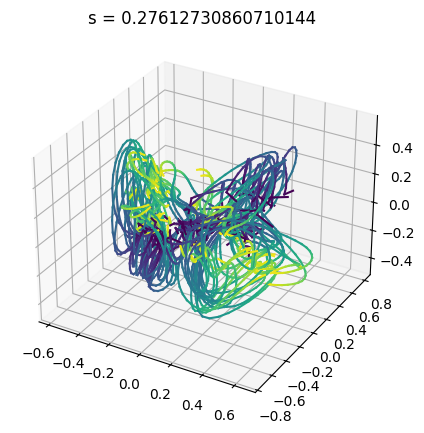

In [2]:
X_pca = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy").swapaxes(1,2)
#X_pca = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy") #.swapaxes(1,2)
#X_pca = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/aug_behaviour.npy")
#X_pca = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
K, N, T = X_pca.shape
#X_pca, _ = pre_processing(X_pca, soft_normalize='max', pca=False, center=True)
X_pca, _ = pre_processing(X_pca, soft_normalize=None, pca=False, center=True)
X_reshaped = X_pca.swapaxes(1,2).reshape(-1, N)

num_pcs = 10
pca = PCA(num_pcs)
Y_pca = pca.fit(X_reshaped).transform(X_reshaped) #train, test 
PCs = pca.components_
Y_pca = Y_pca.reshape(K, T, num_pcs).swapaxes(1,2) #split
pca_variance_captured = pca.explained_variance_ratio_

plot_3D(Y_pca)
plt.title(f's = {compute_S_all_pairs(jnp.array(Y_pca))}')
#plt.title(f"pca {var_explained(X_pca, PCs.T):.2f}")
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_spikes/Y_pca_{num_pcs}d', Y_pca)


#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/var_explained', pca_variance_captured)

variance captured ratio 0.3315856089549271


Text(0.5, 1.0, 's = 0.4527822732925415')

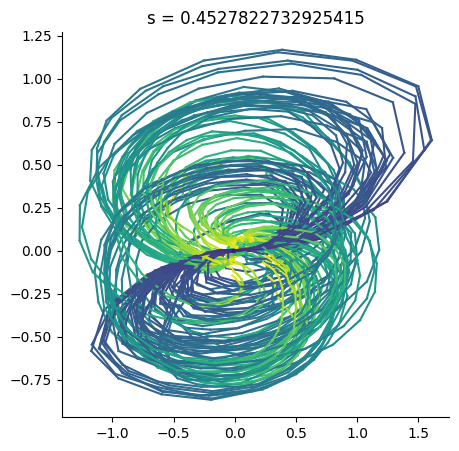

In [2]:
""" jPCA """
#X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
#X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
X = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/aug_behaviour.npy")
X_jpca, _ = pre_processing(X, soft_normalize='max', num_pcs=6)
X_jpca_ls = [X_jpca[i].T for i in range(X_jpca.shape[0])]
times = np.arange(-250, 450, 20).tolist()   

num_jpcs=2
jpca = jPCA.JPCA(num_jpcs=num_jpcs)
(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt) = jpca.fit(X_jpca_ls, times=times, tstart=times[0], tend=times[-1], soft_normalize=0, subtract_cc_mean=False, pca=False) 

jpcs = jpca.jpcs
print(f"variance captured ratio {var_explained(X_jpca, jpcs)}")                 #:.2f

Y_jpca = jnp.array((X_jpca_ls @ jpcs).swapaxes(1,2))
#print(f's = {compute_S_all_pairs(Y_jpca)}')

plot_2D(Y_jpca)
plt.title(f's = {compute_S_all_pairs(Y_jpca)}')
#plt.savefig(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/jpca_spikes/projection_jpca_{num_jpcs}d.png')
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/jpca_spikes/Y_jpca_{num_jpcs}d', Y_pca)

<Figure size 640x480 with 0 Axes>

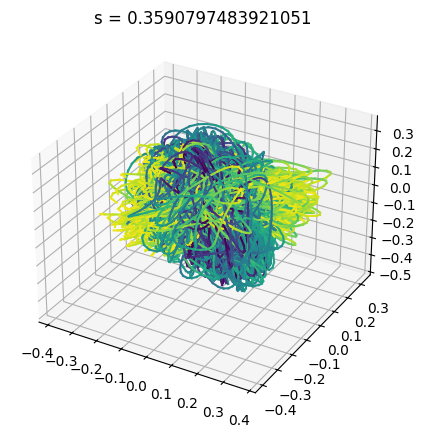

In [21]:
A = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/A_softNormMax_centerFalse_spikes.npy')
X = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerFalse_spikes.npy')

save_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/neural_spikes'
kernel = 'gaussian'
kernel_function = K_X_Y_squared_exponential
d = 10
K, N, T = X.shape

params = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/neural_spikes/params_{d}d_{kernel}.npy', allow_pickle=True).tolist()

_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, _, _   = get_alpha(params, A, X, kernel_function, d)
X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)
plt.figure()
plot_3D(Y)
plt.title(f's = {compute_S_all_pairs(Y)}')
plt.savefig(f'{save_path}/projection_fig_{d}d_{kernel}.png')
np.save(f'{save_path}/projection_{d}d_{kernel}', Y)
# plt.figure()
# get_loss_fig(ls_loss, ls_S_ratio)
# plt.savefig(f'{save_path}/loss_fig_{d}d_{kernel}.png')
# np.save(f'{save_path}/ls_loss_{d}d_{kernel}', np.array(ls_loss))
# np.save(f'{save_path}/ls_S_ratio_{d}d_{kernel}', np.array(ls_S_ratio))